# Problema:  Prever se um cliente vai cancelar sua assinatura

In [239]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install jupyter
#!pip install shap
#!pip install torchmetrics

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')


In [241]:
url = '../data/raw/Sony_data.csv'
df = pd.read_csv(url)
df.head()

,Estado,Tempo_conta,Codigo_area,Numero_telefone,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,...,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Cancelamento
0,KS,128,415,382-4657,nao,sim,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,nao,sim,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,nao,nao,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,sim,nao,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,sim,nao,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [242]:
# Divisão em treino e teste
X = df.drop(columns=['Cancelamento'])
y = df['Cancelamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Conjunto de treino: ", X_train.shape)
print("Conjunto de teste: ", X_test.shape)

Conjunto de treino:  (2666, 20)
Conjunto de teste:  (667, 20)


# Processamento dos dados

In [244]:
X_train.head(5)

,Estado,Tempo_conta,Codigo_area,Numero_telefone,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,352-2270,nao,sim,30,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,8,3.54,0
86,IN,94,408,402-1251,nao,nao,0,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,5,2.16,4
1349,KY,71,510,403-1953,nao,sim,22,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,3,1.51,2
1649,NH,130,408,390-4003,nao,nao,0,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,4,2.81,0
3000,NJ,87,510,387-2799,nao,nao,0,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,4,3.92,3


In [245]:
X_train.describe(include='object')

,Estado,Numero_telefone,Plano_internacional,Plano_correio
count,2666,2666,2666,2666
unique,51,2666,2,2
top,WV,352-2270,nao,nao
freq,89,1,2411,1934


In [246]:
# Corrigir tipo
def correct_type(df_origem):
  df_origem['Codigo_area'] = df_origem['Codigo_area'].astype('object')
  return df_origem

In [247]:
X_train = correct_type(X_train)
X_test = correct_type(X_test)

In [248]:
X_train.describe(include='object')

,Estado,Codigo_area,Numero_telefone,Plano_internacional,Plano_correio
count,2666,2666,2666,2666,2666
unique,51,3,2666,2,2
top,WV,415,352-2270,nao,nao
freq,89,1336,1,2411,1934


In [249]:
# Deletar colunas inúteis
def delete_column(df_origem):
  df_origem = df_origem.drop('Numero_telefone', axis=1)
  return df_origem

In [250]:
X_train = delete_column(X_train)
X_test = delete_column(X_test)

Text(0, 0.5, 'Frequencia')

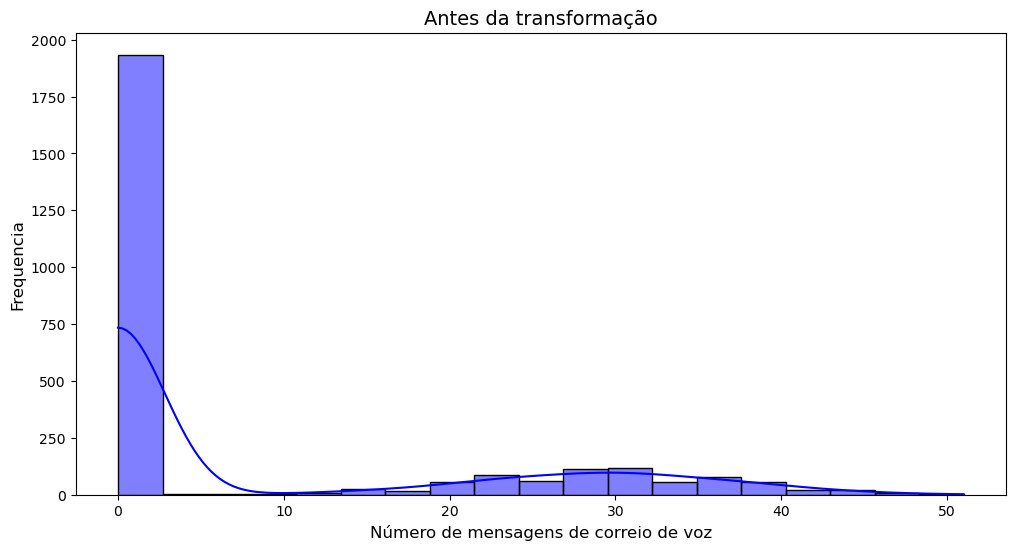

In [252]:
#Distribuição original
plt.figure(figsize=(12, 6))

sns.histplot(X_train['Numero_mensagens_voz'], kde=True, color='blue')
plt.title('Antes da transformação', fontsize=14)
plt.xlabel('Número de mensagens de correio de voz', fontsize=12)
plt.ylabel('Frequencia', fontsize=12)

In [253]:
# Binning em dois 2 bins: 0-20, 20+
def binning(df_origem, bins,labels, columns):
  df_origem[columns] = pd.cut(df_origem[columns], bins=bins, labels=labels, right=False)
  return df_origem

In [254]:
bins = [0, 21, np.inf]
labels = ['Baixo', 'Alto']

X_train = binning(X_train, bins,labels, 'Numero_mensagens_voz')
X_test = binning(X_test, bins,labels, 'Numero_mensagens_voz')

In [255]:
X_train.head(5)

,Estado,Tempo_conta,Codigo_area,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,nao,sim,Alto,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,8,3.54,0
86,IN,94,408,nao,nao,Baixo,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,5,2.16,4
1349,KY,71,510,nao,sim,Alto,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,3,1.51,2
1649,NH,130,408,nao,nao,Baixo,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,4,2.81,0
3000,NJ,87,510,nao,nao,Baixo,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,4,3.92,3


Text(0, 0.5, 'Frequência')

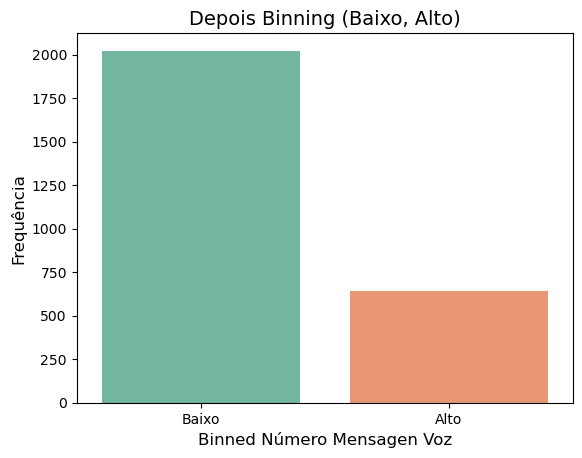

In [256]:
# Frequência depois do bining
sns.countplot(x='Numero_mensagens_voz', data=X_train, palette='Set2')
plt.title('Depois Binning (Baixo, Alto)', fontsize=14)
plt.xlabel('Binned Número Mensagen Voz', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

In [257]:
# Binning em 3 bins: 0-2, 3-4, 4+
bins = [0, 3, 5, np.inf]
labels = ['Baixo', 'Médio', 'Alto']

X_train = binning(X_train, bins,labels,'Chamadas_atendimento')
X_test = binning(X_test, bins,labels,'Chamadas_atendimento')

In [258]:
X_train.head(5)

,Estado,Tempo_conta,Codigo_area,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,nao,sim,Alto,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,8,3.54,Baixo
86,IN,94,408,nao,nao,Baixo,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,5,2.16,Médio
1349,KY,71,510,nao,sim,Alto,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,3,1.51,Baixo
1649,NH,130,408,nao,nao,Baixo,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,4,2.81,Baixo
3000,NJ,87,510,nao,nao,Baixo,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,4,3.92,Médio


Text(0, 0.5, 'Frequência')

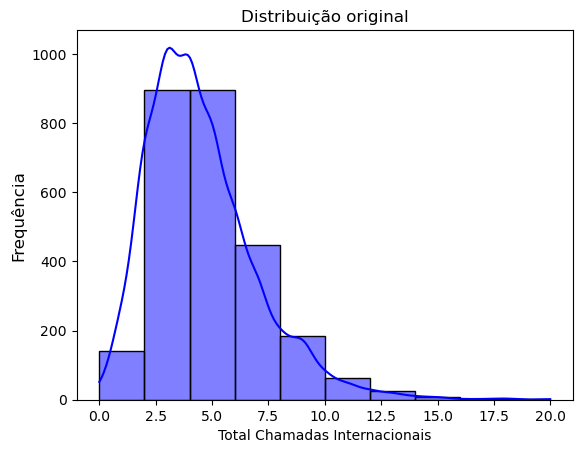

In [259]:
sns.histplot(X_train['Total_chamadas_internacionais'], bins=10, kde=True, color='blue')
plt.title('Distribuição original')
plt.xlabel('Total Chamadas Internacionais')
plt.ylabel('Frequência', fontsize=12)

In [260]:
# Aplicando log transformation para reduzir skewness (adicionando 1 para evitar log(0))
def log_transformation(df_origem):
  df_origem['Total_chamadas_internacionais'] = np.log1p(df_origem['Total_chamadas_internacionais'])
  return df_origem

In [261]:
X_train = log_transformation(X_train)
X_test = log_transformation(X_test)

In [262]:
X_train.head(5)

,Estado,Tempo_conta,Codigo_area,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,nao,sim,Alto,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,2.197225,3.54,Baixo
86,IN,94,408,nao,nao,Baixo,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,1.791759,2.16,Médio
1349,KY,71,510,nao,sim,Alto,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,1.386294,1.51,Baixo
1649,NH,130,408,nao,nao,Baixo,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,1.609438,2.81,Baixo
3000,NJ,87,510,nao,nao,Baixo,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,1.609438,3.92,Médio


Text(0, 0.5, 'Frequência')

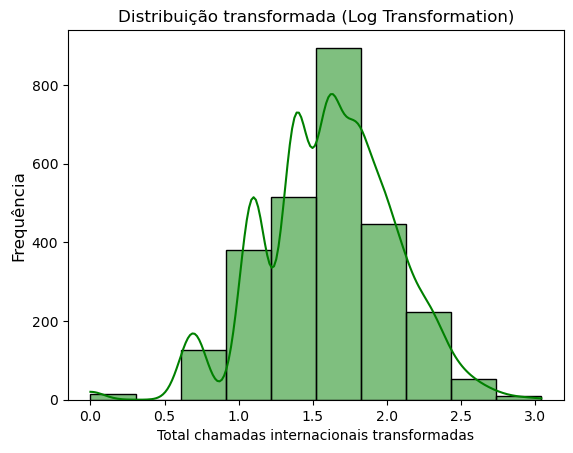

In [263]:
sns.histplot(X_train['Total_chamadas_internacionais'], bins=10, kde=True, color='green')
plt.title('Distribuição transformada (Log Transformation)')
plt.xlabel('Total chamadas internacionais transformadas')
plt.ylabel('Frequência', fontsize=12)

In [264]:
X_train.head(5)

,Estado,Tempo_conta,Codigo_area,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,nao,sim,Alto,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,2.197225,3.54,Baixo
86,IN,94,408,nao,nao,Baixo,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,1.791759,2.16,Médio
1349,KY,71,510,nao,sim,Alto,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,1.386294,1.51,Baixo
1649,NH,130,408,nao,nao,Baixo,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,1.609438,2.81,Baixo
3000,NJ,87,510,nao,nao,Baixo,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,1.609438,3.92,Médio


In [265]:
X_train.select_dtypes(include=['object','category']).columns

Index(['Estado', 'Codigo_area', 'Plano_internacional', 'Plano_correio',
       'Numero_mensagens_voz', 'Chamadas_atendimento'],
      dtype='object')

In [266]:
# Aplicando One-Hot Encoding
def one_hot_encoder(df_origem):
  df_origem = pd.get_dummies(df_origem, columns=['Codigo_area'])
  return df_origem

In [267]:
X_train_copy = one_hot_encoder(X_train)
X_test_copy = one_hot_encoder(X_test)
X_train_copy.head(5)

,Estado,Tempo_conta,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,...,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Codigo_area_408,Codigo_area_415,Codigo_area_510
3286,OH,106,nao,sim,Alto,220.1,105,37.42,222.2,109,...,158.4,96,7.13,13.1,2.197225,3.54,Baixo,False,True,False
86,IN,94,nao,nao,Baixo,157.9,105,26.84,155.0,101,...,189.6,84,8.53,8.0,1.791759,2.16,Médio,True,False,False
1349,KY,71,nao,sim,Alto,141.4,107,24.04,163.0,105,...,220.0,99,9.90,5.6,1.386294,1.51,Baixo,False,False,True
1649,NH,130,nao,nao,Baixo,68.4,86,11.63,193.3,110,...,171.5,139,7.72,10.4,1.609438,2.81,Baixo,True,False,False
3000,NJ,87,nao,nao,Baixo,223.2,109,37.94,127.5,86,...,289.3,83,13.02,14.5,1.609438,3.92,Médio,False,False,True


In [268]:
# Aplicando mapping: encoding da variável booleana Cancelamento
def mapping_target(df_origem):
    if isinstance(df_origem, pd.DataFrame):
        boolean_cols = df_origem.select_dtypes(include=['bool']).columns
        df_origem[boolean_cols] = df_origem[boolean_cols].applymap(lambda x: 1 if x else 0)
        return df_origem
    elif isinstance(df_origem, pd.Series) and df_origem.dtype == 'bool':
        return df_origem.map({True: 1, False: 0})

In [269]:
X_train_copy = mapping_target(X_train_copy)
X_test_copy = mapping_target(X_test_copy)

y_train = mapping_target(y_train)
y_test = mapping_target(y_test)

X_train_copy.head(5)

,Estado,Tempo_conta,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,...,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Codigo_area_408,Codigo_area_415,Codigo_area_510
3286,OH,106,nao,sim,Alto,220.1,105,37.42,222.2,109,...,158.4,96,7.13,13.1,2.197225,3.54,Baixo,0,1,0
86,IN,94,nao,nao,Baixo,157.9,105,26.84,155.0,101,...,189.6,84,8.53,8.0,1.791759,2.16,Médio,1,0,0
1349,KY,71,nao,sim,Alto,141.4,107,24.04,163.0,105,...,220.0,99,9.90,5.6,1.386294,1.51,Baixo,0,0,1
1649,NH,130,nao,nao,Baixo,68.4,86,11.63,193.3,110,...,171.5,139,7.72,10.4,1.609438,2.81,Baixo,1,0,0
3000,NJ,87,nao,nao,Baixo,223.2,109,37.94,127.5,86,...,289.3,83,13.02,14.5,1.609438,3.92,Médio,0,0,1


In [270]:
y_train

3286    0
86      1
1349    0
1649    0
3000    0
       ..
2670    0
2165    0
2988    0
179     0
2762    0
Name: Cancelamento, Length: 2666, dtype: int64

In [271]:
X_train['Plano_internacional'].unique()

array(['nao', 'sim'], dtype=object)

In [272]:
X_train['Plano_correio'].unique()

array(['sim', 'nao'], dtype=object)

In [273]:
X_train['Numero_mensagens_voz'].unique()

['Alto', 'Baixo']
Categories (2, object): ['Baixo' < 'Alto']

In [274]:
X_train['Chamadas_atendimento'].unique()

['Baixo', 'Médio', 'Alto']
Categories (3, object): ['Baixo' < 'Médio' < 'Alto']

In [275]:
# Aplicando Label Encoder
def label_encoder(df_origem):
  le = LabelEncoder()
  df_origem['Plano_internacional'] = le.fit_transform(df_origem['Plano_internacional'])
  df_origem['Plano_correio'] = le.fit_transform(df_origem['Plano_correio'])
  df_origem['Chamadas_atendimento'] = le.fit_transform(df_origem['Chamadas_atendimento'])
  df_origem['Numero_mensagens_voz'] = le.fit_transform(df_origem['Numero_mensagens_voz'])
  return df_origem

In [276]:
X_train = label_encoder(X_train)
X_test = label_encoder(X_test)

In [277]:
X_train.head()

,Estado,Tempo_conta,Codigo_area,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento
3286,OH,106,415,0,1,0,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,2.197225,3.54,1
86,IN,94,408,0,0,1,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,1.791759,2.16,2
1349,KY,71,510,0,1,0,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,1.386294,1.51,1
1649,NH,130,408,0,0,1,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,1.609438,2.81,1
3000,NJ,87,510,0,0,1,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,1.609438,3.92,2


In [278]:
X_train['Codigo_area'] = X_train['Codigo_area'].astype(int)
X_test['Codigo_area'] = X_test['Codigo_area'].astype(int)
X_train['Codigo_area'].unique()

array([415, 408, 510])

In [279]:
# Aplicando Target Encoding
def target_encoding(X, y, column1, column2):
    X_temp = X.copy()
    X_temp['Cancelamento'] = y

    mean_cancelamento = X_temp.groupby(column1)['Cancelamento'].mean()
    X[column2] = X[column1].map(mean_cancelamento)
    X.drop(columns=[column1], inplace=True)
    return X

In [280]:
X_train = target_encoding(X_train, y_train,'Estado','Media_cancelamento_por_estado')
X_train = target_encoding(X_train, y_train,'Codigo_area','Media_cancelamento_por_codigo_area')

X_test = target_encoding(X_test, y_test, 'Estado','Media_cancelamento_por_estado')
X_test = target_encoding(X_test, y_test, 'Codigo_area','Media_cancelamento_por_codigo_area')

X_train.head()

,Tempo_conta,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_cobrancas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Media_cancelamento_por_estado,Media_cancelamento_por_codigo_area
3286,106,0,1,0,220.1,105,37.42,222.2,109,18.89,158.4,96,7.13,13.1,2.197225,3.54,1,0.152542,0.148204
86,94,0,0,1,157.9,105,26.84,155.0,101,13.18,189.6,84,8.53,8.0,1.791759,2.16,2,0.160714,0.136095
1349,71,0,1,0,141.4,107,24.04,163.0,105,13.86,220.0,99,9.90,5.6,1.386294,1.51,1,0.122449,0.146789
1649,130,0,0,1,68.4,86,11.63,193.3,110,16.43,171.5,139,7.72,10.4,1.609438,2.81,1,0.127660,0.136095
3000,87,0,0,1,223.2,109,37.94,127.5,86,10.84,289.3,83,13.02,14.5,1.609438,3.92,2,0.264151,0.146789


In [281]:
# Criando novas colunas
def feature_engineering(df_origem):
  df_origem['Total_chamadas_diurnas_por_minuto'] = df_origem['Total_cobrancas_diurnas'] / df_origem['Total_minutos_diurnos']
  df_origem['Total_chamadas_vespertinas_por_minuto'] = df_origem['Total_cobrancas_vespertinas'] / df_origem['Total_minutos_vespertinos']
  df_origem['Total_chamadas_noturnas_por_minuto'] = df_origem['Total_cobrancas_noturnas'] / df_origem['Total_minutos_noturnos']
  df_origem['Total_chamadas_internacionais_por_minuto'] = df_origem['Total_cobrancas_internacionais'] / df_origem['Total_minutos_internacionais']
  return df_origem

In [282]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

X_train.head()

,Tempo_conta,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,...,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Media_cancelamento_por_estado,Media_cancelamento_por_codigo_area,Total_chamadas_diurnas_por_minuto,Total_chamadas_vespertinas_por_minuto,Total_chamadas_noturnas_por_minuto,Total_chamadas_internacionais_por_minuto
3286,106,0,1,0,220.1,105,37.42,222.2,109,18.89,...,13.1,2.197225,3.54,1,0.152542,0.148204,0.170014,0.085014,0.045013,0.270229
86,94,0,0,1,157.9,105,26.84,155.0,101,13.18,...,8.0,1.791759,2.16,2,0.160714,0.136095,0.169981,0.085032,0.044989,0.270000
1349,71,0,1,0,141.4,107,24.04,163.0,105,13.86,...,5.6,1.386294,1.51,1,0.122449,0.146789,0.170014,0.085031,0.045000,0.269643
1649,130,0,0,1,68.4,86,11.63,193.3,110,16.43,...,10.4,1.609438,2.81,1,0.127660,0.136095,0.170029,0.084997,0.045015,0.270192
3000,87,0,0,1,223.2,109,37.94,127.5,86,10.84,...,14.5,1.609438,3.92,2,0.264151,0.146789,0.169982,0.085020,0.045005,0.270345


In [283]:
X_train.head(5)

,Tempo_conta,Plano_internacional,Plano_correio,Numero_mensagens_voz,Total_minutos_diurnos,Total_chamadas_diurnas,Total_cobrancas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_cobrancas_vespertinas,...,Total_minutos_internacionais,Total_chamadas_internacionais,Total_cobrancas_internacionais,Chamadas_atendimento,Media_cancelamento_por_estado,Media_cancelamento_por_codigo_area,Total_chamadas_diurnas_por_minuto,Total_chamadas_vespertinas_por_minuto,Total_chamadas_noturnas_por_minuto,Total_chamadas_internacionais_por_minuto
3286,106,0,1,0,220.1,105,37.42,222.2,109,18.89,...,13.1,2.197225,3.54,1,0.152542,0.148204,0.170014,0.085014,0.045013,0.270229
86,94,0,0,1,157.9,105,26.84,155.0,101,13.18,...,8.0,1.791759,2.16,2,0.160714,0.136095,0.169981,0.085032,0.044989,0.270000
1349,71,0,1,0,141.4,107,24.04,163.0,105,13.86,...,5.6,1.386294,1.51,1,0.122449,0.146789,0.170014,0.085031,0.045000,0.269643
1649,130,0,0,1,68.4,86,11.63,193.3,110,16.43,...,10.4,1.609438,2.81,1,0.127660,0.136095,0.170029,0.084997,0.045015,0.270192
3000,87,0,0,1,223.2,109,37.94,127.5,86,10.84,...,14.5,1.609438,3.92,2,0.264151,0.146789,0.169982,0.085020,0.045005,0.270345


Text(0.5, 1.0, 'Matriz de Correlação de Pearson')

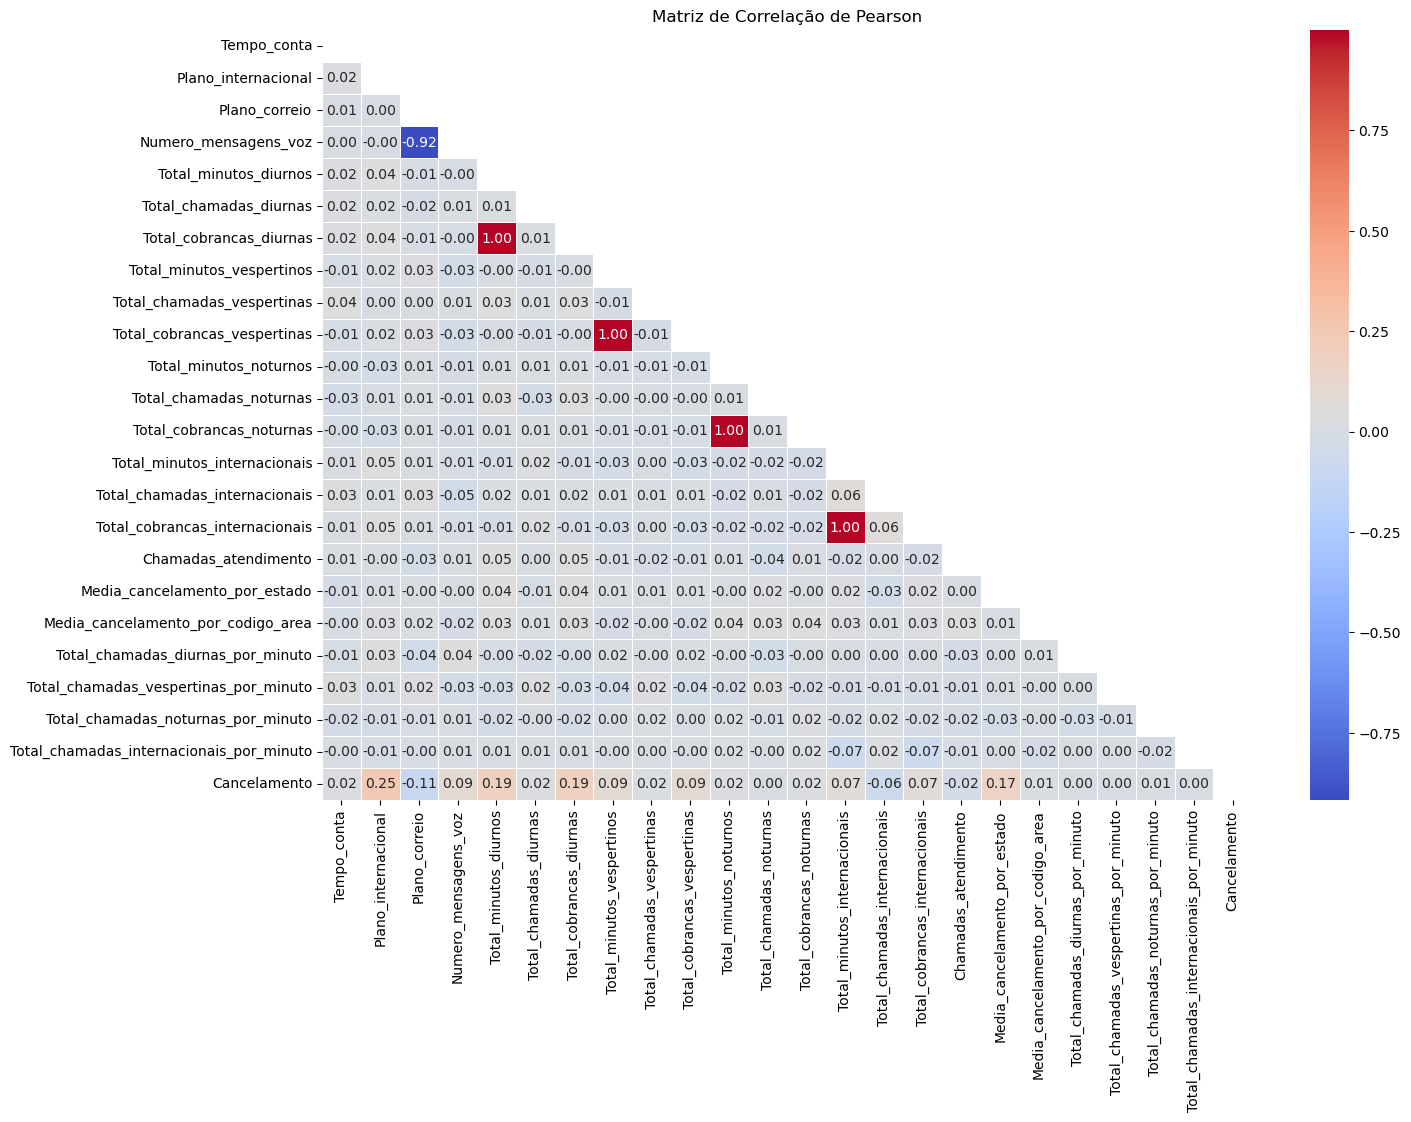

In [284]:
pearson_correlation_matrix = pd.concat([X_train, y_train], axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(pearson_correlation_matrix, dtype=bool))
plt.figure(figsize=(15, 10))
sns.heatmap(pearson_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"fontsize": 10}, mask=mask)
plt.title('Matriz de Correlação de Pearson')

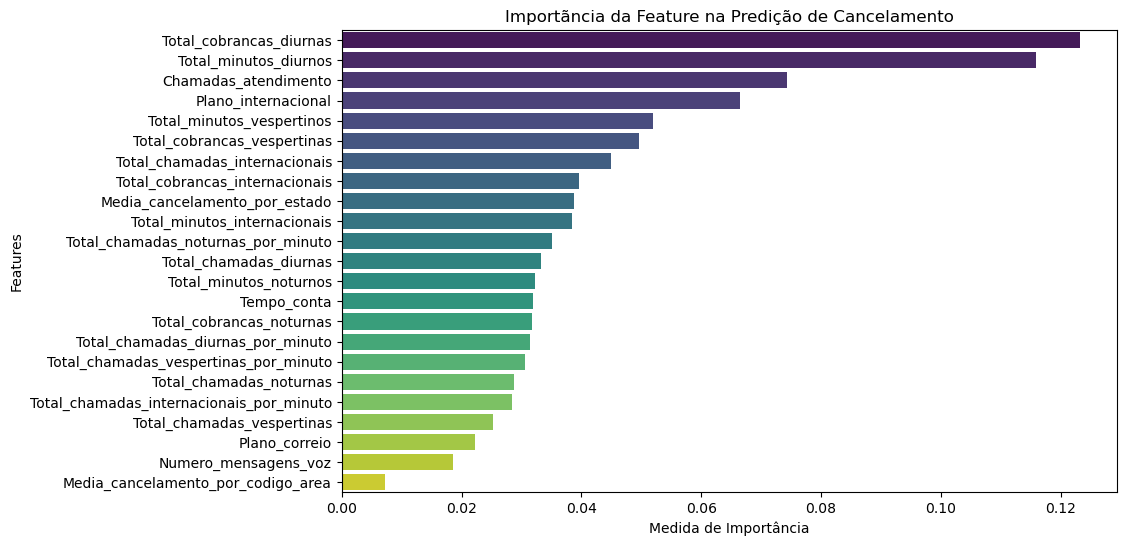

In [285]:
# Recuperar as features mais importantes
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns,'Importancia': importance}).sort_values(by='Importancia', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importãncia da Feature na Predição de Cancelamento')
plt.xlabel('Medida de Importância')
plt.ylabel('Features')
plt.show()

In [286]:
# Calcula a variância de cada coluna (ou variável) em X_train.
# A variância mede a dispersão dos dados em torno da média.
# Quanto maior a variância, mais dispersos são os valores em uma variável.

variance = X_train.var()
variance.sort_values(ascending=False)

Total_minutos_diurnos                       2.953812e+03
Total_minutos_vespertinos                   2.549148e+03
Total_minutos_noturnos                      2.495654e+03
Tempo_conta                                 1.589500e+03
Total_chamadas_diurnas                      4.005118e+02
Total_chamadas_vespertinas                  4.000536e+02
Total_chamadas_noturnas                     3.835425e+02
Total_cobrancas_diurnas                     8.536550e+01
Total_cobrancas_vespertinas                 1.841724e+01
Total_minutos_internacionais                7.861339e+00
Total_cobrancas_noturnas                    5.053885e+00
Total_cobrancas_internacionais              5.730819e-01
Plano_correio                               1.992554e-01
Total_chamadas_internacionais               1.930660e-01
Chamadas_atendimento                        1.876116e-01
Numero_mensagens_voz                        1.832777e-01
Plano_internacional                         8.653266e-02
Media_cancelamento_por_estado  

In [287]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [288]:
# Retirando algumas colunas
columns_to_drop = ['Total_cobrancas_diurnas', 'Total_cobrancas_noturnas', 'Total_cobrancas_vespertinas',
                   'Total_cobrancas_internacionais', 'Numero_mensagens_voz', 'Total_chamadas_diurnas_por_minuto',
                   'Total_chamadas_vespertinas_por_minuto', 'Total_chamadas_internacionais_por_minuto']

X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)
X_train.head()

,Tempo_conta,Plano_internacional,Plano_correio,Total_minutos_diurnos,Total_chamadas_diurnas,Total_minutos_vespertinos,Total_chamadas_vespertinas,Total_minutos_noturnos,Total_chamadas_noturnas,Total_minutos_internacionais,Total_chamadas_internacionais,Chamadas_atendimento,Media_cancelamento_por_estado,Media_cancelamento_por_codigo_area,Total_chamadas_noturnas_por_minuto
3286,106,0,1,220.1,105,222.2,109,158.4,96,13.1,2.197225,1,0.152542,0.148204,0.045013
86,94,0,0,157.9,105,155.0,101,189.6,84,8.0,1.791759,2,0.160714,0.136095,0.044989
1349,71,0,1,141.4,107,163.0,105,220.0,99,5.6,1.386294,1,0.122449,0.146789,0.045000
1649,130,0,0,68.4,86,193.3,110,171.5,139,10.4,1.609438,1,0.127660,0.136095,0.045015
3000,87,0,0,223.2,109,127.5,86,289.3,83,14.5,1.609438,2,0.264151,0.146789,0.045005


#### Balanceando a classe

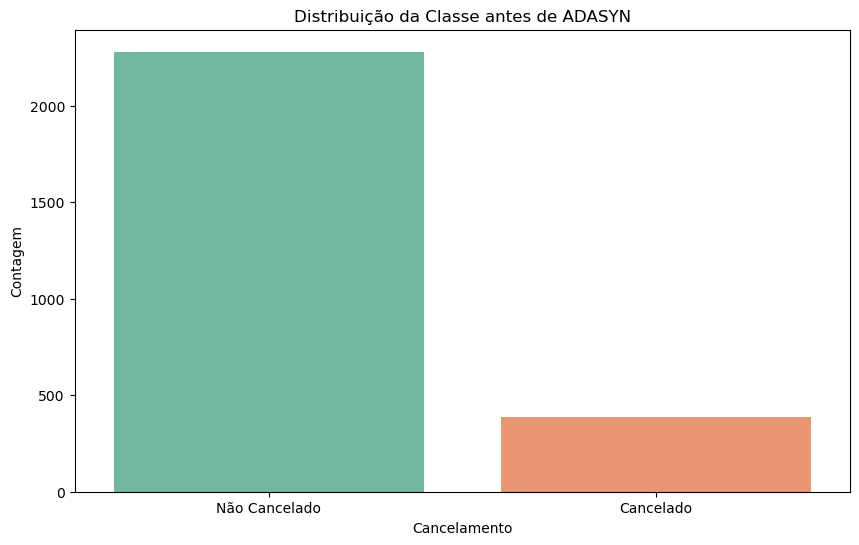

In [290]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cancelamento', data=pd.concat([X_train, y_train], axis=1), palette='Set2')
plt.title('Distribuição da Classe antes de ADASYN')
plt.xlabel('Cancelamento')
plt.ylabel('Contagem')
plt.xticks([0, 1], labels=['Não Cancelado', 'Cancelado'])
plt.show()

In [291]:
# Aplicando o balanceamento de classes
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

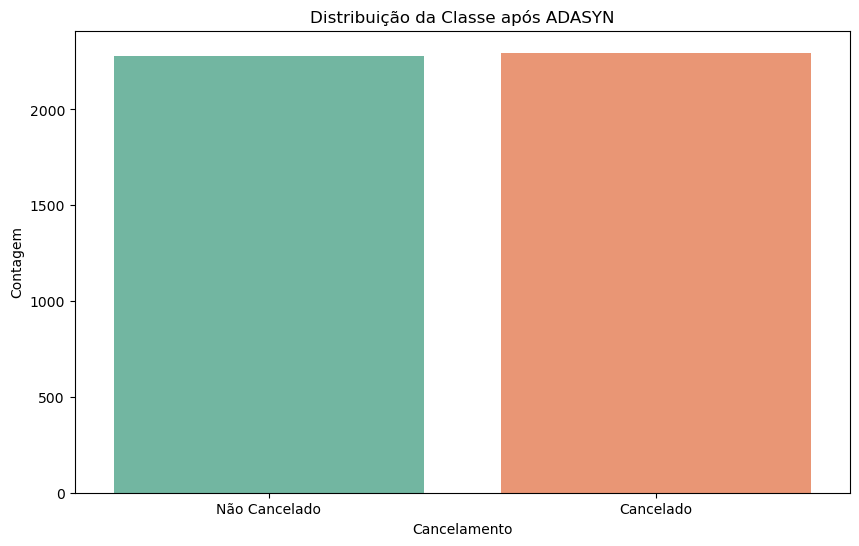

In [292]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cancelamento', data=pd.concat([X_resampled, y_resampled], axis=1), palette='Set2')
plt.title('Distribuição da Classe após ADASYN')
plt.xlabel('Cancelamento')
plt.ylabel('Contagem')
plt.xticks([0, 1], labels=['Não Cancelado', 'Cancelado'])
plt.show()

In [293]:
before_count = pd.Series(y_train).value_counts()
after_count = pd.Series(y_resampled).value_counts()

comparison_df = pd.DataFrame({
    'Antes': before_count,
   'Depois': after_count
})

comparison_df

,Antes,Depois
Cancelamento,,
0,2280,2280
1,386,2296


In [294]:
# Aplicando a normalização dos dados
def scaling(df_origem):
  scaler = RobustScaler()
  columns_to_scale = ['Tempo_conta', 'Total_minutos_diurnos','Total_chamadas_diurnas','Total_minutos_vespertinos','Total_chamadas_vespertinas','Total_minutos_noturnos','Total_chamadas_noturnas','Total_minutos_internacionais']
  df_origem[columns_to_scale] = scaler.fit_transform(df_origem[columns_to_scale])
  joblib.dump(scaler, '../models/scaler.pkl')
  return df_origem

In [295]:
X_train = scaling(X_train)
X_test = scaling(X_test)

In [297]:
X_train.to_csv('../data/train/X_train.csv', index=False)
y_train.to_csv('../data/train/y_train.csv', index=False)
X_test.to_csv('../data/train/X_test.csv', index=False)
y_test.to_csv('../data/train/y_test.csv', index=False)

In [298]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2666 entries, 3286 to 2762
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Tempo_conta                         2666 non-null   float64
 1   Plano_internacional                 2666 non-null   int32  
 2   Plano_correio                       2666 non-null   int32  
 3   Total_minutos_diurnos               2666 non-null   float64
 4   Total_chamadas_diurnas              2666 non-null   float64
 5   Total_minutos_vespertinos           2666 non-null   float64
 6   Total_chamadas_vespertinas          2666 non-null   float64
 7   Total_minutos_noturnos              2666 non-null   float64
 8   Total_chamadas_noturnas             2666 non-null   float64
 9   Total_minutos_internacionais        2666 non-null   float64
 10  Total_chamadas_internacionais       2666 non-null   float64
 11  Chamadas_atendimento                2666 non-